In [10]:
import sys
sys.path.append('../') 
from imports import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import ParameterGrid



In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [12]:
torch.cuda.is_available()

True

In [13]:
X_train = pd.read_csv('./breast-cancer-processed-data/X_train.csv').values
y_train = pd.read_csv('./breast-cancer-processed-data/y_train.csv').values
X_val = pd.read_csv('./breast-cancer-processed-data/X_val.csv').values
y_val = pd.read_csv('./breast-cancer-processed-data/y_val.csv').values
X_test = pd.read_csv('./breast-cancer-processed-data/X_test.csv').values
y_test = pd.read_csv('./breast-cancer-processed-data/y_test.csv').values

array([1])

In [32]:
# Convert Numpy arrays to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=1)

/tmp/ipykernel_5647/1444445010.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_5647/1444445010.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
/tmp/ipykernel_5647/1444445010.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torc

In [18]:
class FNN(nn.Module):
    def __init__(self, input_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [27]:
model = FNN(X_train.shape[1]).to(device)
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [28]:
def calculate_accuracy(y_pred, y_true):
    # Convert predictions to binary values (0 or 1)
    
    predicted = torch.round(y_pred).view(-1)
    y_true = y_true.squeeze()
    return (predicted == y_true).sum().float() / len(y_true)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
# Training and validation for certain epochs
epochs = 100
for epoch in range(epochs):  # number of epochs
    model.train()
    total_loss, total_acc = 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += calculate_accuracy(output, target)
        
    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    
    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            val_acc += calculate_accuracy(output, target)
            
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}')



Epoch 1, Training Loss: 0.6741, Training Accuracy: 0.6328, Validation Loss: 0.6311, Validation Accuracy: 0.8360
Epoch 2, Training Loss: 0.5906, Training Accuracy: 0.8976, Validation Loss: 0.5578, Validation Accuracy: 0.9109
Epoch 3, Training Loss: 0.5207, Training Accuracy: 0.9280, Validation Loss: 0.4924, Validation Accuracy: 0.9460
Epoch 4, Training Loss: 0.4502, Training Accuracy: 0.9349, Validation Loss: 0.4338, Validation Accuracy: 0.9460
Epoch 5, Training Loss: 0.4019, Training Accuracy: 0.9288, Validation Loss: 0.3806, Validation Accuracy: 0.9564
Epoch 6, Training Loss: 0.3531, Training Accuracy: 0.9358, Validation Loss: 0.3361, Validation Accuracy: 0.9564
Epoch 7, Training Loss: 0.3103, Training Accuracy: 0.9384, Validation Loss: 0.2977, Validation Accuracy: 0.9564
Epoch 8, Training Loss: 0.2817, Training Accuracy: 0.9427, Validation Loss: 0.2649, Validation Accuracy: 0.9564
Epoch 9, Training Loss: 0.2500, Training Accuracy: 0.9453, Validation Loss: 0.2377, Validation Accuracy:

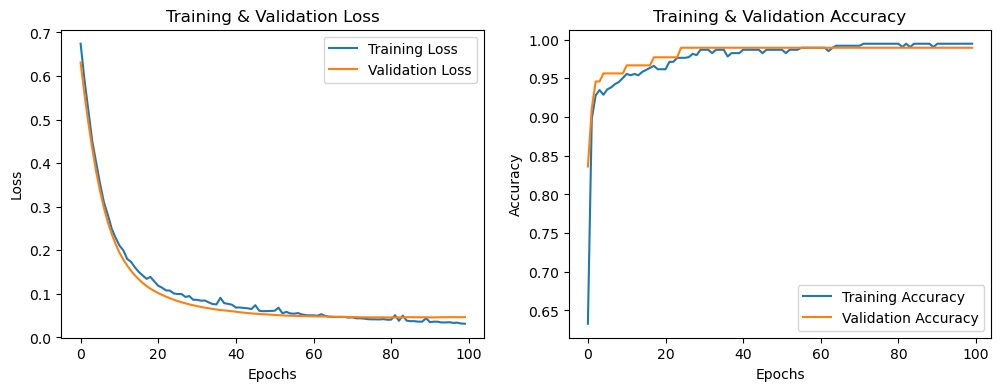

In [29]:
import matplotlib.pyplot as plt

# Plotting training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
train_accuracies = [acc.cpu().numpy() for acc in train_accuracies]
val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [33]:
# Testing the model
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()

        # For accuracy calculation
        predicted = torch.round(output).view(-1)  # Assuming binary classification
        correct += (predicted == target).sum().item()
        total += target.size(0)

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.0567, Test Accuracy: 98.25%


In [42]:
# Now let us perform hyperparamter tuning to find optimal parameters and replace them where needed!
# Defining the parametr grid for hyperparameter tuning
param_grid = {
    'lr': [0.0001, 0.0005, 0.005, 0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100]
}

In [48]:
def calculate_accuracy(y_pred, y_true):
    # Convert predictions to binary values (0 or 1)
    y_pred, y_true = y_pred.squeeze(), y_true.squeeze()
    predicted = torch.round(y_pred).view(-1)
    return (predicted == y_true).sum().float() / len(y_true)

In [49]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_acc = 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_acc += calculate_accuracy(output, target)
            
        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                val_acc += calculate_accuracy(output, target)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

    return avg_val_loss, avg_val_acc


In [50]:
best_val_acc = 0
best_params = {}

for params in ParameterGrid(param_grid):
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=params['batch_size'])

    model = FNN(X_train.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    val_loss, val_acc = train_and_validate(model, train_loader, val_loader, criterion, optimizer, params['epochs'])

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params

    print(f"Params: {params}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}%")

print(f"Best Params: {best_params}, Best Validation Accuracy: {best_val_acc:.4f}%")


Params: {'batch_size': 16, 'epochs': 50, 'lr': 0.0001}, Validation Loss: 0.1158, Validation Accuracy: 0.9792%
Params: {'batch_size': 16, 'epochs': 50, 'lr': 0.0005}, Validation Loss: 0.0509, Validation Accuracy: 0.9896%
Params: {'batch_size': 16, 'epochs': 50, 'lr': 0.005}, Validation Loss: 0.1198, Validation Accuracy: 0.9792%
Params: {'batch_size': 16, 'epochs': 50, 'lr': 0.001}, Validation Loss: 0.0455, Validation Accuracy: 0.9896%
Params: {'batch_size': 16, 'epochs': 50, 'lr': 0.01}, Validation Loss: 0.1371, Validation Accuracy: 0.9792%
Params: {'batch_size': 16, 'epochs': 100, 'lr': 0.0001}, Validation Loss: 0.0616, Validation Accuracy: 0.9896%
Params: {'batch_size': 16, 'epochs': 100, 'lr': 0.0005}, Validation Loss: 0.0477, Validation Accuracy: 0.9896%
Params: {'batch_size': 16, 'epochs': 100, 'lr': 0.005}, Validation Loss: 0.1537, Validation Accuracy: 0.9792%
Params: {'batch_size': 16, 'epochs': 100, 'lr': 0.001}, Validation Loss: 0.0669, Validation Accuracy: 0.9792%
Params: {'ba

In [51]:
model = FNN(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# Convert Numpy arrays to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=1)

def calculate_accuracy(y_pred, y_true):
    # Convert predictions to binary values (0 or 1)

    predicted = torch.round(y_pred).view(-1)
    y_true = y_true.squeeze()
    return (predicted == y_true).sum().float() / len(y_true)


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
# Training and validation for certain epochs
epochs = 50
for epoch in range(epochs):  # number of epochs
    model.train()
    total_loss, total_acc = 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += calculate_accuracy(output, target)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            val_acc += calculate_accuracy(output, target)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    print(
        f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}')



/tmp/ipykernel_5647/1012127265.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_5647/1012127265.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
/tmp/ipykernel_5647/1012127265.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torc

Epoch 1, Training Loss: 0.6098, Training Accuracy: 0.8196, Validation Loss: 0.5834, Validation Accuracy: 0.9132
Epoch 2, Training Loss: 0.5683, Training Accuracy: 0.8703, Validation Loss: 0.5444, Validation Accuracy: 0.9395
Epoch 3, Training Loss: 0.5300, Training Accuracy: 0.9001, Validation Loss: 0.5074, Validation Accuracy: 0.9580
Epoch 4, Training Loss: 0.4989, Training Accuracy: 0.9148, Validation Loss: 0.4725, Validation Accuracy: 0.9737
Epoch 5, Training Loss: 0.4638, Training Accuracy: 0.9209, Validation Loss: 0.4401, Validation Accuracy: 0.9737
Epoch 6, Training Loss: 0.4347, Training Accuracy: 0.9183, Validation Loss: 0.4094, Validation Accuracy: 0.9737
Epoch 7, Training Loss: 0.4033, Training Accuracy: 0.9233, Validation Loss: 0.3809, Validation Accuracy: 0.9737
Epoch 8, Training Loss: 0.3828, Training Accuracy: 0.9188, Validation Loss: 0.3540, Validation Accuracy: 0.9737
Epoch 9, Training Loss: 0.3599, Training Accuracy: 0.9238, Validation Loss: 0.3292, Validation Accuracy:

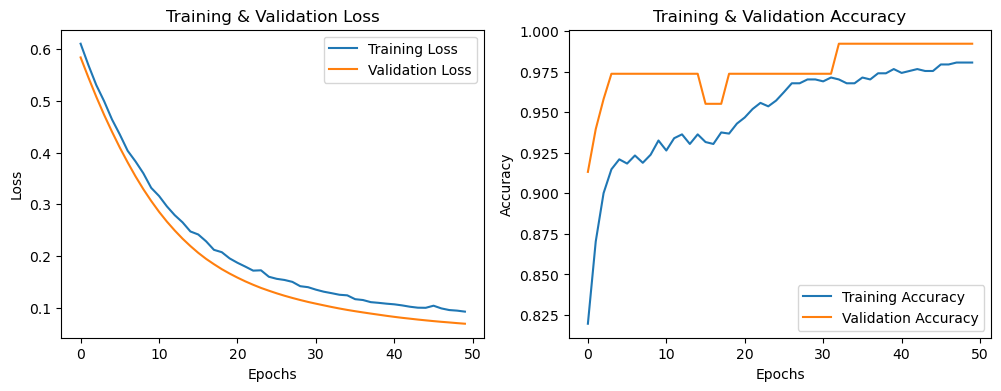

In [52]:

# Plotting training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
train_accuracies = [acc.cpu().numpy() for acc in train_accuracies]
val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




In [53]:
# Testing the model
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()

        # For accuracy calculation
        predicted = torch.round(output).view(-1)  # Assuming binary classification
        correct += (predicted == target).sum().item()
        total += target.size(0)

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0793, Test Accuracy: 99.12%
